# Import packages

In [1]:
import pandas as pd
import numpy as np
import parse
import re
import seaborn as sns
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

from ProcessHTML import ProcessHTML
from ExtractRooms import ExtractRooms
from GeneralizeDataset import GeneralizeDataset

# Preprocess dataset
## HTML Texts

In [2]:
filename = "../datasets/PropertyData_wDesc.csv"
data = pd.read_csv(filename, encoding="ISO8859-1")

In [3]:
handler = ProcessHTML()

rooms = data["EweMove Description S3 Rooms"]
price = data["Price / Rent"]

for room in rooms:
    handler.EweMove_Description_S3_Rooms(room)
for p in price:
    handler.price_rent(p)

In [4]:
indices = set(range(len(data)))
room_indices = set(i for i in range(len(handler.s3_rooms)) if handler.s3_rooms[i] is not None)
price_indices = set(i for i in range(len(handler.price_or_rent)) if handler.price_or_rent[i][0] != 0)

In [5]:
valid_indices = indices & room_indices & price_indices

## Categorical data

In [6]:
generalize = GeneralizeDataset(data)

parking = generalize.get_feature_num("parking")
outside = generalize.get_feature_num("outside_space")
heating = generalize.get_feature_num("heating")
accessibility = generalize.get_feature_num("accessibility")

In [7]:
condition_indices = set(i for i in indices if data["RTD3316_condition1 - Condition Description"].notna()[i])
qualifier_indices = set(i for i in indices if data["Price Qualifier"].notna()[i])
council_tax_indices = set(i for i in indices if data["DESC Council Tax Band"].notna()[i])

In [8]:
valid_indices = valid_indices & condition_indices & qualifier_indices & council_tax_indices

# Obtain the dataset for model input

In [9]:
parking_names = [i for i in data.columns if "parking" in i]
outside_names = [i for i in data.columns if "outside" in i]
heating_names = [i for i in data.columns if "heating" in i]
accessibility_names = [i for i in data.columns if "accessibility" in i]
condition_names = [i for i in data.columns if "condition" in i]
column_names = ["Postcode", "Sale or Let", "EweMove Description S3 Rooms", "Price / Rent",
                "Price Qualifier", "DESC Council Tax Band", "# of Enquiry or viewings", "# of Apps/Offers"]
column_names += parking_names + outside_names + heating_names + accessibility_names + condition_names

valid_indices = sorted(list(valid_indices))
input_data = data.iloc[valid_indices][column_names]
input_data.head()

,Postcode,Sale or Let,EweMove Description S3 Rooms,Price / Rent,Price Qualifier,DESC Council Tax Band,# of Enquiry or viewings,# of Apps/Offers,RTD3307_parking1 - Parking Description,RTD3307_parking2 - Parking Description,...,RTD3308_outside_space1 - Outside Space Description,RTD3308_outside_space2 - Outside Space Description,RTD3308_outside_space3 - Outside Space Description,RTD3318_heating1 - Heating Description,RTD3318_heating2 - Heating Description,RTD3318_heating3 - Heating Description,RTD3317_accessibility1 - accessibility Description,RTD3317_accessibility2 - accessibility Description,RTD3317_accessibility3 - accessibility Description,RTD3316_condition1 - Condition Description
0,LU7 4WN,Sale,This home includes:<ul><li><strong>01 - Entran...,"<font color='blue'>&pound;140,000</font><br>Of...",Offers In Excess Of,Band B,32,12,Allocated,Off Street,...,Communal Garden,NaN,NaN,Double Glazing,Electric,Night Storage,Not suitable for wheelchair users,NaN,NaN,Good
2,DA17 5PJ,Sale,This home includes:<ul><li><strong>01 - Entran...,"<font color='blue'>&pound;325,000</font><br>Gu...",Guide Price,Band D,14,4,On Street,NaN,...,Rear Garden,Private Garden,NaN,Central,Gas Central,Double Glazing,NaN,NaN,NaN,Good
6,RG26 5PX,Sale,This home includes:<ul><li><strong>01 - Living...,"<font color='blue'>&pound;500,000</font><br>Gu...",Guide Price,Band E,10,2,Driveway,Garage,...,Back Garden,Enclosed Garden,Patio,Double Glazing,Gas Central,Under Floor,NaN,NaN,NaN,Good
7,BD8 0HT,Sale,This home includes:<ul><li><strong>01 - Hallwa...,"<font color='blue'>&pound;170,000</font><br>Of...",Offers in Region Of,Band B,9,1,Driveway,NaN,...,Front Garden,Rear Garden,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good
15,HU17 7AB,Sale,This home includes:<ul><li><strong>01 - Entran...,"<font color='blue'>&pound;410,000</font><br>Of...",Offers Over,Band B,1,2,Off Street,Allocated,...,Rear Garden,NaN,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good


In [10]:
general_data = input_data.loc[:, ~input_data.columns.isin(["EweMove Description S3 Rooms", "Price / Rent"])]
general_data.head()

,Postcode,Sale or Let,Price Qualifier,DESC Council Tax Band,# of Enquiry or viewings,# of Apps/Offers,RTD3307_parking1 - Parking Description,RTD3307_parking2 - Parking Description,RTD3307_parking3 - Parking Description,RTD3308_outside_space1 - Outside Space Description,RTD3308_outside_space2 - Outside Space Description,RTD3308_outside_space3 - Outside Space Description,RTD3318_heating1 - Heating Description,RTD3318_heating2 - Heating Description,RTD3318_heating3 - Heating Description,RTD3317_accessibility1 - accessibility Description,RTD3317_accessibility2 - accessibility Description,RTD3317_accessibility3 - accessibility Description,RTD3316_condition1 - Condition Description
0,LU7 4WN,Sale,Offers In Excess Of,Band B,32,12,Allocated,Off Street,Residents,Communal Garden,NaN,NaN,Double Glazing,Electric,Night Storage,Not suitable for wheelchair users,NaN,NaN,Good
2,DA17 5PJ,Sale,Guide Price,Band D,14,4,On Street,NaN,NaN,Rear Garden,Private Garden,NaN,Central,Gas Central,Double Glazing,NaN,NaN,NaN,Good
6,RG26 5PX,Sale,Guide Price,Band E,10,2,Driveway,Garage,Off Street,Back Garden,Enclosed Garden,Patio,Double Glazing,Gas Central,Under Floor,NaN,NaN,NaN,Good
7,BD8 0HT,Sale,Offers in Region Of,Band B,9,1,Driveway,NaN,NaN,Front Garden,Rear Garden,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good
15,HU17 7AB,Sale,Offers Over,Band B,1,2,Off Street,Allocated,NaN,Rear Garden,NaN,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good


## Price for sale and rental

In [11]:
prices = [handler.price_or_rent[i][0] for i in valid_indices]
prices = pd.DataFrame(prices)
rename_dict = {i: j for i, j in zip(range(len(prices)), valid_indices)}
prices = prices.rename(index=rename_dict)

### Sale price

Text(0.5, 1.0, 'Sale Price')

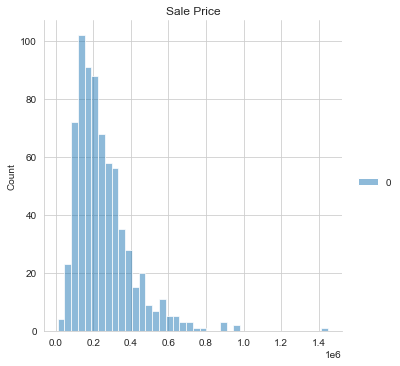

In [12]:
sale_prices = prices[general_data["Sale or Let"] == "Sale"]
sns.displot(sale_prices)
plt.title("Sale Price")

Text(0.5, 1.0, 'Rental Price')

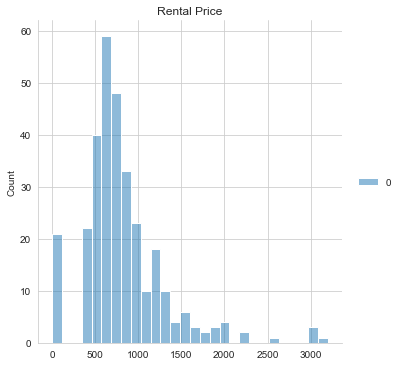

In [13]:
rental_price = prices[general_data["Sale or Let"] == "Rental"]
sns.displot(rental_price)
plt.title("Rental Price")

## Extract room information

In [14]:
rooms = [handler.s3_rooms[i] for i in valid_indices]
extract_room = ExtractRooms(rooms, handler.s3_rooms_set, "{} ({} sqm){}")

### Bedrooms

In [15]:
bedrooms = extract_room.get_rooms("bedroom")

In [16]:
bedrooms = pd.DataFrame(bedrooms)
rename_dict = {str(i): "bedroom {}".format(i + 1) for i in range(6)}
bedrooms = bedrooms.rename(columns=rename_dict)
bedrooms.head()

,bedroom 1,bedroom 2,bedroom 3,bedroom 4,bedroom 5,bedroom 6
0,8.2,6.2,0.0,0.0,0.0,0.0
1,13.1,7.7,10.4,0.0,0.0,0.0
2,13.7,9.4,9.6,0.0,0.0,0.0
3,13.6,8.6,5.2,0.0,0.0,0.0
4,14.9,13.1,14.6,0.0,0.0,0.0


### Kitchens

In [17]:
kitchens = extract_room.get_rooms("kitchen", operation="number")

In [18]:
kitchens = pd.DataFrame(kitchens)
kitchens = kitchens.rename(columns={0: "kitchen number"})
kitchens.head()

,kitchen number
0,1
1,1
2,1
3,1
4,1


### Living/Reception

In [19]:
receptions = extract_room.get_rooms("living", "reception", operation="sum")

In [20]:
receptions = pd.DataFrame(receptions)
receptions = receptions.rename(columns={0: "living area"})
receptions.head()

,living area
0,24.8
1,0.0
2,17.8
3,18.1
4,0.0


### Bathrooms

In [21]:
bathrooms = extract_room.get_rooms("bathroom", "wc", "washroom", operation="number")

In [22]:
bathrooms = pd.DataFrame(bathrooms)
bathrooms = bathrooms.rename(columns={0: "bathroom number"})
bathrooms.head()

,bathroom number
0,1
1,2
2,0
3,1
4,0


### Dining

In [23]:
dining_rooms = extract_room.get_rooms("dining", operation="number")

In [24]:
dining_rooms = pd.DataFrame(dining_rooms)
dining_rooms = dining_rooms.rename(columns={0: "dining number"})
dining_rooms.head()

,dining number
0,1
1,0
2,1
3,1
4,1


### Other spaces

In [25]:
others = extract_room.get_rest_rooms()

In [26]:
others = pd.DataFrame(others)
others = others.rename(columns={0: "other number", 1: "other area"})
others.head()

,other number,other area
0,3,0.0
1,4,27.3
2,2,17.2
3,4,19.5
4,8,36.9


In [27]:
room_info = pd.concat([bedrooms, kitchens, receptions, bathrooms, dining_rooms, others], axis=1)
room_info.head()

,bedroom 1,bedroom 2,bedroom 3,bedroom 4,bedroom 5,bedroom 6,kitchen number,living area,bathroom number,dining number,other number,other area
0,8.2,6.2,0.0,0.0,0.0,0.0,1,24.8,1,1,3,0.0
1,13.1,7.7,10.4,0.0,0.0,0.0,1,0.0,2,0,4,27.3
2,13.7,9.4,9.6,0.0,0.0,0.0,1,17.8,0,1,2,17.2
3,13.6,8.6,5.2,0.0,0.0,0.0,1,18.1,1,1,4,19.5
4,14.9,13.1,14.6,0.0,0.0,0.0,1,0.0,0,1,8,36.9


In [81]:
from sklearn.preprocessing import LabelEncoder

data.head()

,Postcode,Created,Advertised,Agreed,Completed,Date Listing Last Cancelled,Sale or Let,RTD3308_outside_space1 - Outside Space Description,EweMove Description S1 Features,EweMove Description S2 Description,...,Price / Rent,Price Qualifier,Sale Price % Achieved,Current EPC - EPC Expiry Date,DESC Council Tax Band,DESC Leasehold Ground Rent,DESC Leasehold Service Charge,ZPG_lease_expiry_years_remaining,# of Enquiry or viewings,# of Apps/Offers
0,LU7 4WN,03/04/2019,03/04/2019,NaN,NaN,28/02/2022,Sale,Communal Garden,<ul><li>CASH BUYERS ONLY</li><li>No Upper Chai...,Cash Buyers... You could pounce super quick on...,...,"<font color='blue'>&pound;140,000</font><br>Of...",Offers In Excess Of,130.71%,11/03/2028,Band B,NaN,NaN,68.0,32,12
1,L23 6YD,21/03/2019,24/03/2019,05/04/2021,28/06/2021,26/02/2020,Sale,NaN,<ul><li>Sea Views</li><li>Very Popular Locatio...,WATCHING THE SHIPS ROLL IN - from your very ow...,...,"<font color='blue'>&pound;325,000</font><br>Of...",Offers Over,NaN,28/03/2029,Band E,NaN,NaN,NaN,15,10
2,DA17 5PJ,25/03/2019,03/04/2019,25/01/2021,15/03/2021,13/06/2019,Sale,Rear Garden,<ul><li>Call NOW 24/7 or book instantly online...,"Guide price &pound;325,000 - &pound;350,000.Lo...",...,"<font color='blue'>&pound;325,000</font><br>Gu...",Guide Price,NaN,12/07/2028,Band D,NaN,NaN,NaN,14,4
3,NW4 1AP,28/06/2019,04/07/2019,NaN,NaN,NaN,Sale,NaN,<ul><li>5 bed link detached FREEHOLD house wit...,EweMove Hampstead - A rare opportunity to acqu...,...,"<font color='blue'>&pound;1,095,000</font><br>...",Guide Price,NaN,30/06/2029,NaN,NaN,NaN,NaN,13,1
4,GL7 5UX,12/06/2019,09/08/2019,13/04/2021,05/07/2021,NaN,Sale,Back Garden,<ul><li>Four Bedrooms</li><li>Detached</li><li...,For anyone looking for a family home in South ...,...,"<font color='blue'>&pound;395,000</font><br>",NaN,100.00%,30/06/2024,NaN,NaN,NaN,NaN,11,9


In [85]:
encoder = LabelEncoder()
encoder.fit(data.Postcode)
data.Postcode = pd.DataFrame(encoder.transform(data.Postcode))

In [86]:
data

,Postcode,Created,Advertised,Agreed,Completed,Date Listing Last Cancelled,Sale or Let,RTD3308_outside_space1 - Outside Space Description,EweMove Description S1 Features,EweMove Description S2 Description,...,Price / Rent,Price Qualifier,Sale Price % Achieved,Current EPC - EPC Expiry Date,DESC Council Tax Band,DESC Leasehold Ground Rent,DESC Leasehold Service Charge,ZPG_lease_expiry_years_remaining,# of Enquiry or viewings,# of Apps/Offers
0,1595,03/04/2019,03/04/2019,NaN,NaN,28/02/2022,Sale,Communal Garden,<ul><li>CASH BUYERS ONLY</li><li>No Upper Chai...,Cash Buyers... You could pounce super quick on...,...,"<font color='blue'>&pound;140,000</font><br>Of...",Offers In Excess Of,130.71%,11/03/2028,Band B,NaN,NaN,68.0,32,12
1,1229,21/03/2019,24/03/2019,05/04/2021,28/06/2021,26/02/2020,Sale,NaN,<ul><li>Sea Views</li><li>Very Popular Locatio...,WATCHING THE SHIPS ROLL IN - from your very ow...,...,"<font color='blue'>&pound;325,000</font><br>Of...",Offers Over,NaN,28/03/2029,Band E,NaN,NaN,NaN,15,10
2,389,25/03/2019,03/04/2019,25/01/2021,15/03/2021,13/06/2019,Sale,Rear Garden,<ul><li>Call NOW 24/7 or book instantly online...,"Guide price &pound;325,000 - &pound;350,000.Lo...",...,"<font color='blue'>&pound;325,000</font><br>Gu...",Guide Price,NaN,12/07/2028,Band D,NaN,NaN,NaN,14,4
3,1890,28/06/2019,04/07/2019,NaN,NaN,NaN,Sale,NaN,<ul><li>5 bed link detached FREEHOLD house wit...,EweMove Hampstead - A rare opportunity to acqu...,...,"<font color='blue'>&pound;1,095,000</font><br>...",Guide Price,NaN,30/06/2029,NaN,NaN,NaN,NaN,13,1
4,791,12/06/2019,09/08/2019,13/04/2021,05/07/2021,NaN,Sale,Back Garden,<ul><li>Four Bedrooms</li><li>Detached</li><li...,For anyone looking for a family home in South ...,...,"<font color='blue'>&pound;395,000</font><br>",NaN,100.00%,30/06/2024,NaN,NaN,NaN,NaN,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,2610,28/04/2019,20/05/2019,NaN,NaN,12/12/2019,Sale,Back Garden,<ul><li>Call NOW 24/7 or book instantly online...,"Almere is a popular, private close where homes...",...,"<font color='blue'>&pound;450,000</font><br>Of...",Offers Over,NaN,19/06/2029,Band F,NaN,NaN,NaN,0,0
3645,2296,09/05/2019,12/05/2019,14/05/2019,29/05/2019,NaN,Rental,NaN,<ul></ul>,STUNNING Top floor Balcony Apartment in West ...,...,"<font color='blue'>&pound;1,000</font><br>Monthly",Monthly,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3646,276,12/05/2019,14/05/2019,03/06/2019,21/06/2019,NaN,Rental,Back Garden,<ul><li>Call NOW 24/7 or book instantly online...,An excellent home for a working single or coup...,...,<font color='blue'>&pound;750</font><br>Monthly,Monthly,NaN,23/11/2028,Band A,NaN,NaN,NaN,0,2
3647,2609,22/05/2019,22/05/2019,28/05/2019,21/06/2019,NaN,Rental,Back Garden,<ul><li>Call NOW 24/7 or book instantly online...,A detached bungalow on a substantial plot - if...,...,"<font color='blue'>&pound;1,100</font><br>Monthly",Monthly,NaN,10/04/2028,Band D,NaN,NaN,NaN,0,3


In [91]:
encoder.fit(["1", "2", "3"])
encoder.transform(["2"])

array([1])